In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') #忽视警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import jieba
import jieba.analyse
from wordcloud import WordCloud


# 读取数据

In [2]:
df = pd.read_csv("the_queen_of_news_comments.csv")

# 分词

In [3]:
#加载外部分词字典
jieba.load_userdict("userdict.txt")

# 使用jieba进行中文分词
def chinese_segmentation(text):
    words = jieba.cut(text, cut_all=False, HMM=True)
    return " ".join(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.946 seconds.
Prefix dict has been built successfully.


In [4]:
# 对DataFrame的'comments'列应用中文分词
df['comments_segmented'] = df['comments'].apply(chinese_segmentation)

In [5]:
df['comments_segmented']

0       笑 死 了 ， 小混混 无理取闹 还 抢 司机 方向盘 是 直接 导致 事故 发生 的 原因...
1       绷 不住 了 ， 全程 自带 装 b 光环 ➕ 油腻 表情 ， 慢镜头 这么 多 ， 平时 ...
2              当年 HKTV 的 《 导火 新闻 线 》 真是 yyds 这些 剧照 抄 都 不会
3       以前 TVB 真的 是 我 的 挚爱 ， 看到 好评 那么 多 也 怀着 期待 追剧 。 看...
4                当 我 看到 记者 去 现场 比 警察 医生 还 早 的 时候 ， 就 弃剧 了
                              ...                        
2528                                     喜欢 喜欢 有 bug 也 喜欢
2529                                           保持 住别 烂尾 ！
2530                                宫斗   宅斗   司斗   斗来斗去 。
2531                                             粤语版 挺 好看
2532                                            节奏 我 很 喜欢
Name: comments_segmented, Length: 2533, dtype: object

# 同义词替换

In [6]:
# 加载同义词文件
synonym_file_path = 'synonym.txt'
synonym_dict = {}

# 读取同义词文件，创建同义词典，将同义词映射到主词
with open(synonym_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) > 1:
            main_word = parts[0]
            synonyms = parts[1:]
            for synonym in synonyms:
                synonym_dict[synonym] = main_word

# 替换同义词的函数（针对已分词的情况）
def replace_synonyms(words):
    # 使用同义词典替换同义词为主词
    replaced_words = [synonym_dict.get(word, word) for word in words]

    # 将分词结果拼接成字符串
    return " ".join(replaced_words)

# 对 'comments_segmented' 列应用替换同义词的函数
df['comments_segmented'] = df['comments_segmented'].apply(lambda x: replace_synonyms(x.split()))

# 显示替换同义词后的 DataFrame
print(df['comments_segmented'])


0       笑 死 了 ， 小混混 无理取闹 还 抢 司机 方向盘 是 直接 导致 事故 发生 的 原因...
1       绷 不住 了 ， 全程 自带 装 b 光环 ➕ 油腻 表情 ， 慢镜头 这么 多 ， 平时 ...
2              当年 HKTV 的 《 导火 新闻 线 》 真是 yyds 这些 剧照 抄 都 不会
3       以前 TVB 真的 是 我 的 挚爱 ， 看到 好评 那么 多 也 怀着 期待 追剧 。 看...
4                当 我 看到 记者 去 现场 比 警察 医生 还 早 的 时候 ， 就 弃剧 了
                              ...                        
2528                                     喜欢 喜欢 有 bug 也 喜欢
2529                                           保持 住别 烂尾 ！
2530                                      宫斗 宅斗 司斗 斗来斗去 。
2531                                             粤语版 挺 好看
2532                                            节奏 我 很 喜欢
Name: comments_segmented, Length: 2533, dtype: object


# 词频分析

- 没有过滤停用词，纯词频方法

In [29]:
# 将分好词的文本拆分成词语列表
df['comments_segmented_list'] = df['comments_segmented'].str.split()

# 使用explode将词语列表展开为单独的行
df_tokens = df.explode('comments_segmented_list')

# 重新设置索引
df_tokens = df_tokens.reset_index(drop=True)

# 打印结果
df_tokens.comments_segmented_list

0          笑
1          死
2          了
3          ，
4        小混混
        ... 
67272     好看
67273     节奏
67274      我
67275      很
67276     喜欢
Name: comments_segmented_list, Length: 67277, dtype: object

In [34]:
# 词频统计
df_tokens["comments_segmented_list"].value_counts()

comments_segmented_list
，                          5177
的                          3271
。                          1886
了                          1610
是                           895
                           ... 
加塞                            1
晓欣                            1
晓晨                            1
晒干                            1
🫨                             1
Name: count, Length: 9195, dtype: int64

In [36]:
#导出数据
df_tokens["comments_segmented_list"].value_counts().to_excel("freq.xlsx")

# 过滤停用词，并使用tf-idf算法提取关键词

In [7]:
import jieba.analyse
jieba.analyse.set_stop_words('stopwords.txt')
#合并一起
text = ''
for i in range(len(df['comments_segmented'])):
    text += df['comments_segmented'][i]+'\n'
j_r=jieba.analyse.extract_tags(text,topK=20,withWeight=True)
df1 = pd.DataFrame()
df1['word']= [word[0] for word in j_r]  ;df1['freq']=[word[1] for word in j_r]
df1

,word,freq
0,TVB,0.173474
1,职场,0.153879
2,佘诗曼,0.130766
3,剧情,0.120491
4,港剧,0.111879
5,新闻,0.107523
6,文慧心,0.063402
7,好看,0.062108
8,演技,0.057004
9,宫斗,0.050193


# 关键词语义网络分析

In [7]:
from tkinter import _flatten

# 步骤1：从外部文件读取停用词
with open("stopwords.txt", "r", encoding="utf-8") as file:
    stopwords = file.read().splitlines()

# 步骤2：对评论进行分词并过滤停用词
comments_segmented_list = list(map(lambda x: ''.join(x), df['comments_segmented'].tolist()))
content_str = ' '.join(comments_segmented_list).split()

# 过滤停用词
filtered_content = [word for word in content_str if word not in stopwords]

# 过滤停用词后计算词频
word_freq = pd.Series(_flatten(filtered_content)).value_counts()

# 显示前50个词
print(word_freq[:50])


新闻     491
剧      491
职场     413
TVB    394
剧情     358
好      348
佘诗曼    297
港剧     230
好看     222
节奏     184
太      177
喜欢     157
演技     154
文慧心    144
女性     122
集      121
看到     119
记者     117
不错     117
宫斗     114
角色     114
拍      110
这种     109
挺      101
觉得      99
想       98
搞       96
现在      96
内地      95
男人      94
浮夸      94
大女主     93
编剧      88
演员      87
爽剧      80
知道      80
这部      79
宫斗剧     78
后面      75
人物      71
职业      71
女主      71
女王      70
香港      68
马国明     67
工作      65
确实      63
台词      62
烂尾      60
真       60
Name: count, dtype: int64


In [8]:
keywords = word_freq[:50].index
keywords

Index(['新闻', '剧', '职场', 'TVB', '剧情', '好', '佘诗曼', '港剧', '好看', '节奏', '太', '喜欢',
       '演技', '文慧心', '女性', '集', '看到', '记者', '不错', '宫斗', '角色', '拍', '这种', '挺',
       '觉得', '想', '搞', '现在', '内地', '男人', '浮夸', '大女主', '编剧', '演员', '爽剧', '知道',
       '这部', '宫斗剧', '后面', '人物', '职业', '女主', '女王', '香港', '马国明', '工作', '确实',
       '台词', '烂尾', '真'],
      dtype='object')

In [9]:
matrix = np.zeros((len(keywords)+1)*(len(keywords)+1)).reshape(len(keywords)+1, len(keywords)+1).astype(str)
matrix[0][0] = np.NaN
matrix[1:, 0] = matrix[0, 1:] = keywords
matrix

array([['nan', '新闻', '剧', ..., '台词', '烂尾', '真'],
       ['新闻', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['剧', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ...,
       ['台词', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['烂尾', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['真', '0.0', '0.0', ..., '0.0', '0.0', '0.0']], dtype='<U32')

In [10]:
# 将评论按空格分割为单词列表
cont_list = [cont.split() for cont in comments_segmented_list]

# 遍历前50个词频最高的单词
for i, w1 in enumerate(word_freq[:50].index):
    for j, w2 in enumerate(word_freq[:50].index):
        count = 0

        # 遍历每条评论的单词列表
        for cont in cont_list:
            # 检查当前两个单词是否同时出现在同一条评论中
            if w1 in cont and w2 in cont:
                # 检查这两个单词在评论中的位置差距是否为0或1
                if abs(cont.index(w1) - cont.index(w2)) == 0 or abs(cont.index(w1) - cont.index(w2)) == 1:
                    count += 1

        # 将计数结果填充到矩阵的相应位置
        matrix[i + 1][j + 1] = count


In [11]:
matrix

array([['nan', '新闻', '剧', ..., '台词', '烂尾', '真'],
       ['新闻', '358', '5', ..., '0', '0', '0'],
       ['剧', '5', '408', ..., '0', '0', '0'],
       ...,
       ['台词', '0', '0', ..., '58', '0', '0'],
       ['烂尾', '0', '0', ..., '0', '56', '0'],
       ['真', '0', '0', ..., '0', '0', '56']], dtype='<U32')

In [12]:
kwdata = pd.DataFrame(data=matrix)
kwdata.to_csv('关键词共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

In [13]:
kwdata= pd.read_csv('关键词共现矩阵.csv')
kwdata.index = kwdata.iloc[:, 0].tolist()
kwdata_ = kwdata.iloc[:20, 1:21]
kwdata_.astype(int)

,新闻,剧,职场,TVB,剧情,好,佘诗曼,港剧,好看,节奏,太,喜欢,演技,文慧心,女性,集,看到,记者,不错,宫斗
新闻,358,5,6,1,0,1,0,0,0,0,1,1,0,0,0,0,2,0,0,1
剧,5,408,105,17,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
职场,6,105,345,6,0,0,0,1,0,0,0,0,0,1,9,0,0,1,0,8
TVB,1,17,6,354,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0,1
剧情,0,0,0,0,334,3,0,0,0,11,4,1,1,0,0,1,0,0,1,0
好,1,0,0,0,3,305,3,1,1,2,0,10,7,0,0,0,3,0,0,0
佘诗曼,0,0,0,0,0,3,278,0,0,0,0,6,15,0,0,0,3,0,0,0
港剧,0,0,1,2,0,1,0,208,2,0,1,3,0,0,0,0,0,0,0,0
好看,0,1,0,0,0,1,0,2,202,0,14,0,0,0,0,0,1,0,0,0
节奏,0,1,0,1,11,2,0,0,0,176,1,0,0,0,0,1,0,0,8,0


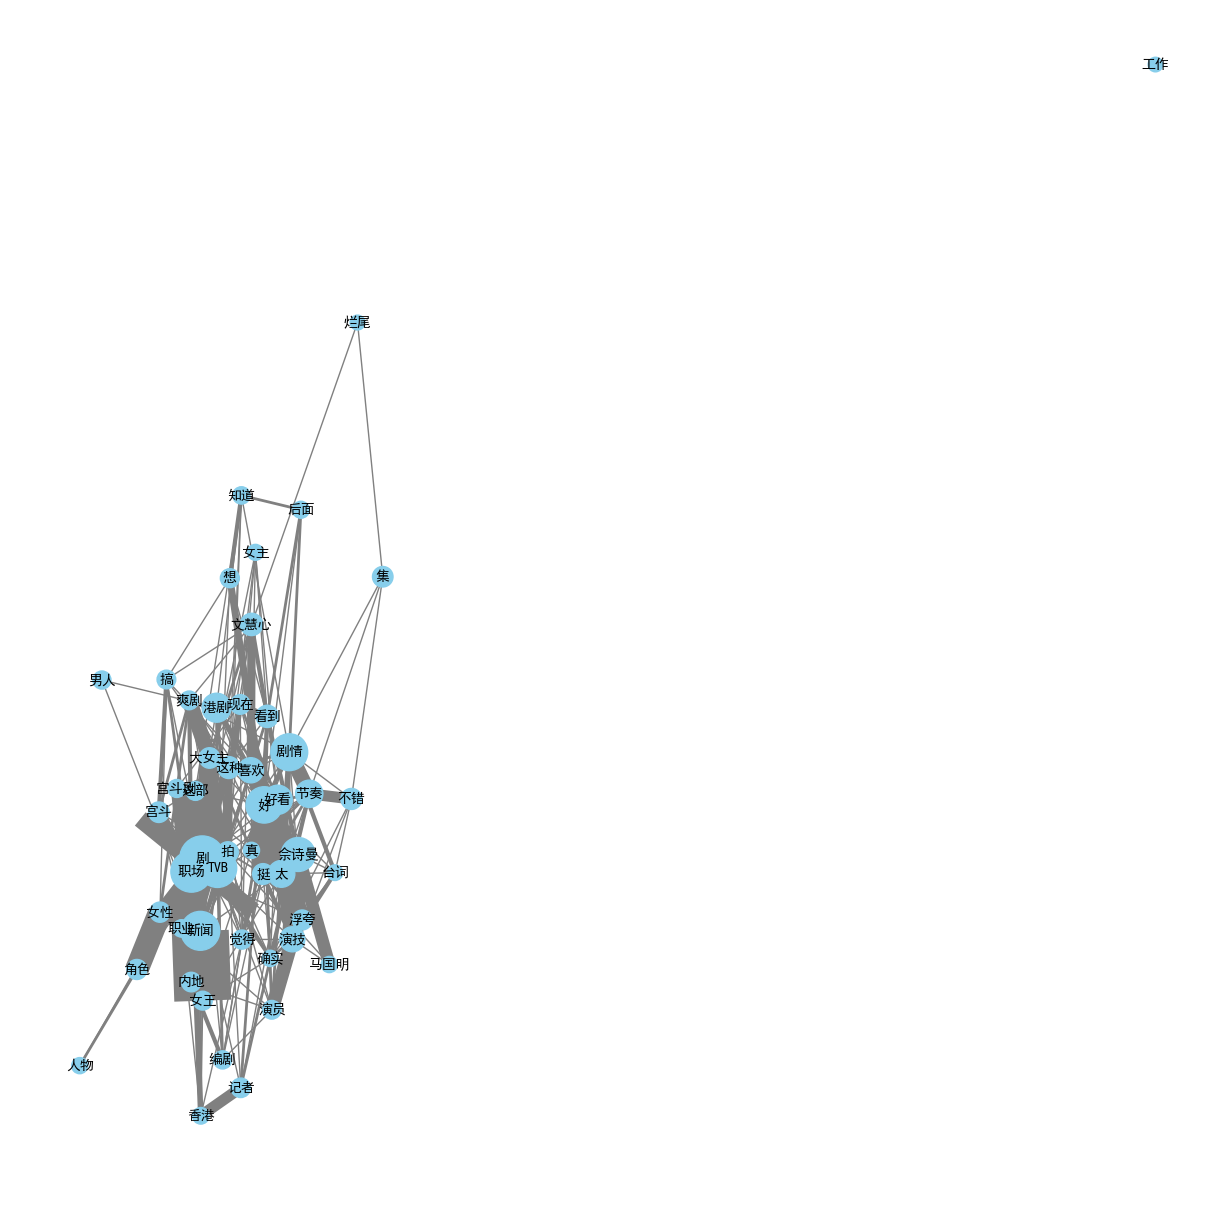

In [44]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取关键词共现矩阵数据
co_occurrence_matrix = pd.read_csv("关键词共现矩阵.csv", index_col=0)

# 创建关键词共现网络图
graph = nx.from_pandas_adjacency(co_occurrence_matrix)

# 计算每个节点的关联强度，作为节点大小
node_weights = dict(graph.degree(weight='weight'))

# 计算每条边的关联强度，这里可以使用边的权重作为关联强度
edge_weights = nx.get_edge_attributes(graph, 'weight')

# 设置布局
pos = nx.spring_layout(graph)

# 绘制网络图，根据关联强度画出线条粗细，排除对角线上的值
plt.figure(figsize=(12, 12))

# 根据节点权重调整节点大小
node_size = [node_weights[node] * 1 for node in graph.nodes()]

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color='skyblue',
    font_size=10,
    node_size=node_size,
    edgelist=[edge for edge in edge_weights if edge[0] != edge[1]],  # 排除对角线上的值
    width=[edge_weights[edge] for edge in edge_weights if edge[0] != edge[1]],
    edge_color='gray',
)

# 显示图像
plt.show()


# 影视剧人物语义网络分析

In [45]:
character_list = ["文慧心", "许诗晴", "张家妍", "徐晓薇", "梁景仁", "余英飞", "方罗丽嫦", "刘艳", "王伟"]

In [46]:
matrix = np.zeros((len(character_list)+1)*(len(character_list)+1)).reshape(len(character_list)+1, len(character_list)+1).astype(str)
matrix[0][0] = np.NaN
matrix[1:, 0] = matrix[0, 1:] = character_list
matrix

array([['nan', '文慧心', '许诗晴', '张家妍', '徐晓薇', '梁景仁', '余英飞', '方罗丽嫦', '刘艳',
        '王伟'],
       ['文慧心', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['许诗晴', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['张家妍', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['徐晓薇', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['梁景仁', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['余英飞', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['方罗丽嫦', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['刘艳', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['王伟', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0']], dtype='<U32')

In [47]:
# 将评论按空格分割为单词列表
cont_list = [cont.split() for cont in comments_segmented_list]

# 遍历影视角色列表
for i, w1 in enumerate(character_list):
    for j, w2 in enumerate(character_list):
        count = 0

        # 遍历每条评论的影视角色列表
        for cont in cont_list:
            # 检查当前两个影视角色是否同时出现在同一条评论中
            if w1 in cont and w2 in cont:
                count += 1

        # 将计数结果填充到矩阵的相应位置
        matrix[i + 1][j + 1] = count


In [48]:
matrix

array([['nan', '文慧心', '许诗晴', '张家妍', '徐晓薇', '梁景仁', '余英飞', '方罗丽嫦', '刘艳',
        '王伟'],
       ['文慧心', '120', '11', '10', '17', '10', '8', '6', '8', '0'],
       ['许诗晴', '11', '40', '4', '12', '1', '1', '2', '2', '2'],
       ['张家妍', '10', '4', '37', '4', '4', '3', '2', '7', '0'],
       ['徐晓薇', '17', '12', '4', '34', '1', '2', '1', '4', '0'],
       ['梁景仁', '10', '1', '4', '1', '14', '2', '2', '3', '0'],
       ['余英飞', '8', '1', '3', '2', '2', '14', '4', '1', '0'],
       ['方罗丽嫦', '6', '2', '2', '1', '2', '4', '11', '0', '0'],
       ['刘艳', '8', '2', '7', '4', '3', '1', '0', '18', '0'],
       ['王伟', '0', '2', '0', '0', '0', '0', '0', '0', '2']], dtype='<U32')

In [49]:
char_data = pd.DataFrame(data=matrix)
char_data.to_csv('人物共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

In [51]:
char_data= pd.read_csv('人物共现矩阵.csv')
char_data.index = char_data.iloc[:, 0].tolist()
char_data_ = char_data.iloc[:20, 1:21]
char_data_.astype(int)

,文慧心,许诗晴,张家妍,徐晓薇,梁景仁,余英飞,方罗丽嫦,刘艳,王伟
文慧心,120,11,10,17,10,8,6,8,0
许诗晴,11,40,4,12,1,1,2,2,2
张家妍,10,4,37,4,4,3,2,7,0
徐晓薇,17,12,4,34,1,2,1,4,0
梁景仁,10,1,4,1,14,2,2,3,0
余英飞,8,1,3,2,2,14,4,1,0
方罗丽嫦,6,2,2,1,2,4,11,0,0
刘艳,8,2,7,4,3,1,0,18,0
王伟,0,2,0,0,0,0,0,0,2


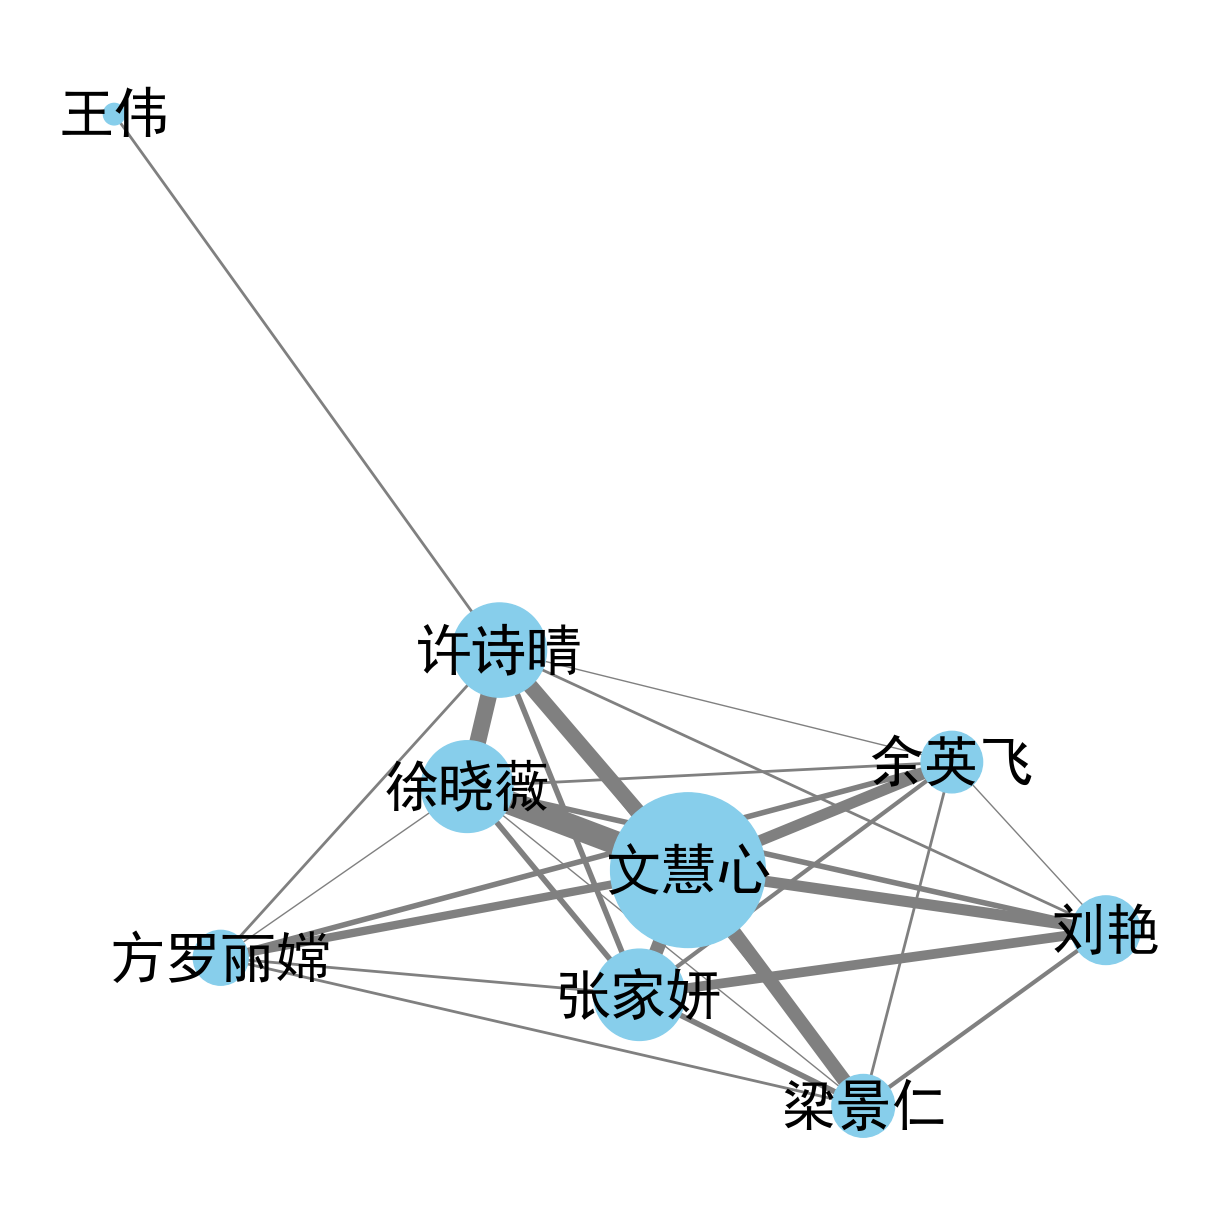

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取人物共现矩阵数据
co_occurrence_matrix = pd.read_csv("人物共现矩阵.csv", index_col=0)

# 创建人物共现网络图
graph = nx.from_pandas_adjacency(co_occurrence_matrix)

# 计算每个节点的关联强度，作为节点大小
node_weights = dict(graph.degree(weight='weight'))

# 计算每条边的关联强度，这里可以使用边的权重作为关联强度
edge_weights = nx.get_edge_attributes(graph, 'weight')

# 设置布局
pos = nx.spring_layout(graph)

# 绘制网络图，根据关联强度画出线条粗细，忽略对角线上的值
plt.figure(figsize=(12, 12))

# 根据节点权重调整其大小
node_size = [node_weights[node] * 40 for node in graph.nodes()]

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color='skyblue',
    font_size=40,
    node_size=node_size,
    edgelist=[edge for edge in edge_weights if edge[0] != edge[1]],  # 排除对角线上的值
    width=[edge_weights[edge] for edge in edge_weights if edge[0] != edge[1]],
    edge_color='gray',
)

# 显示图像
plt.show()


# 提取出分好词的字符串格式的文本

In [8]:
# 对所有'comments_segmented'文本进行拼接
all_comments_text = " ".join(df['comments_segmented'])

In [9]:
all_comments_text

'笑 死 了 ， 小混混 无理取闹 还 抢 司机 方向盘 是 直接 导致 事故 发生 的 原因 ， 没 人 在意 ， 全程 查 这个 ， 查 那个 ， 还 把 司机 以 危险 驾驶 罪捉 了 起来 ， 采访 时说 别人 要 付 全责 ！ ？ 黑人 问号 绷 不住 了 ， 全程 自带 装 b 光环 ➕ 油腻 表情 ， 慢镜头 这么 多 ， 平时 可以 多 看看 TVB 新闻 ， 新闻 主持 语速 要是 这么 慢早 没 工作 了 当年 HKTV 的 《 导火 新闻 线 》 真是 yyds 这些 剧照 抄 都 不会 以前 TVB 真的 是 我 的 挚爱 ， 看到 好评 那么 多 也 怀着 期待 追剧 。 看 了 几集 气得 我 高血压 ， 如果 这 就是 所谓 的 飒 所谓 的 大女主 ， 那 希望 你 日后 的 领导 也 这样 ， 无时无刻 不 在 pua 你 ， 甚至 不 拿 你 的 命 当 人命 。 这 就是 所谓 的 girl power ？ 身体 上位 ？ 愚笨 ？ 对 喷 ？ 明晃晃 把 雌 竞写 脸上 ？ 且 作为 新闻 从业者 ， 真相 与 流量 有 矛盾 我 从不 否认 ， 但 在 直播 的 时候 为了 己方 输赢 没有 商量 的 不顾大局 的 抢 话 互斗 甚至 随意 控制 麦克风 随意 编辑 提词 器 真的 不是 在 侮辱 观众 的 智商 吗 。 看着 各个 平台 都 是 各种 好评 ， 感觉 媒介 素养 是 该 列为 基础教育 了 。 。 。 。 真的 垃圾 ， 别说 啥 跟 内地 比 啥 好 一大截 了 。 。 。 咋 就 不能 比点 好 非得 比烂 呢 。 。 。 当 我 看到 记者 去 现场 比 警察 医生 还 早 的 时候 ， 就 弃剧 了 哪个 龟 犊子 宣传 的 骗 我 来看 这部 电视剧 的 ， 主播 在 直播 过程 中 公然 抢词 互相 对着干 ， 警员 受伤 躺 在 那儿 4 个 小时 没人救 ， 还有 女主 为了 自己 的 职业生涯 pua 小 菜鸟 下属 进 火场 拍摄 ， 还 新闻 女王 ， 新闻 女鬼 吧 ！ 拜托 ， 连 大陆 最 low 的 国产 剧都 知道 拍 成 主角 自己 进 火场 好 吧 ！ 简直 浪费 我 时间 是 我 的 错觉 吗 ？ 看到 8.1 点开 第一集 五分钟 不到 就 被 港剧 一贯 装逼 + 

# 词云分析

- **默认模式**

In [12]:
# 创建词云，并排除停用词
def generate_wordcloud(text):
    # 从外部文件读取停用词列表
    jieba.analyse.set_stop_words("stopwords.txt")
    
    # 使用 jieba.analyse.extract_tags 提取关键词
    keywords = jieba.analyse.extract_tags(text, topK=100, withWeight=True, allowPOS=('n', 'nr', 'ns'))#allowPOS=('n', 'nr', 'ns')：表示仅考虑名词（'n'）、人名（'nr'）、地名（'ns'）等词性的词语作为关键词。这是通过词性标注来筛选关键词的一种方式。

    # 构建关键词和权重的字典
    keywords_dict = {word: weight for word, weight in keywords}

    # 创建词云
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        collocations=False, 
        font_path= r'C:\Windows\Fonts\simhei.ttf',  # 使用支持中文的字体（黑体）
    ).generate_from_frequencies(keywords_dict)
    
    # 显示词云图像
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 生成并显示词云
generate_wordcloud(all_comments_text)

- **带背景模式**

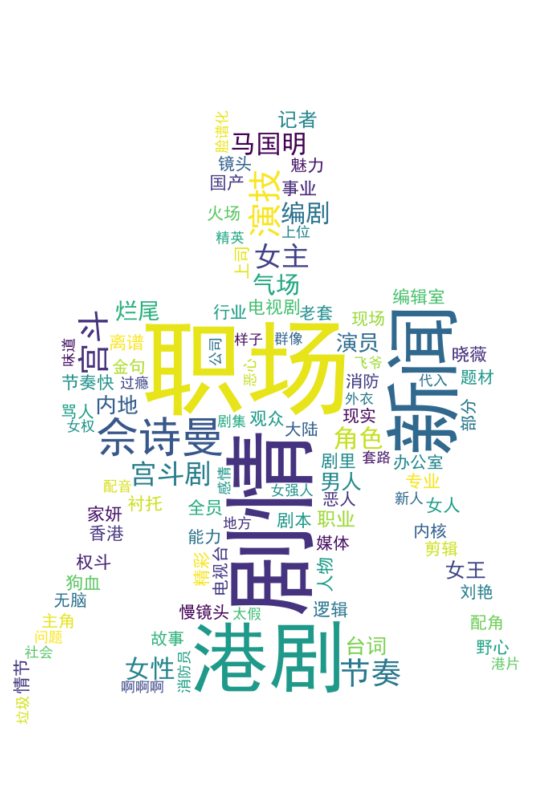

In [14]:
import jieba.analyse
from wordcloud import WordCloud
from imageio import imread
import matplotlib.pyplot as plt

# 从外部文件读取停用词列表
jieba.analyse.set_stop_words("stopwords.txt")

def generate_wordcloud(text):
    # Using jieba.analyse.extract_tags to extract keywords
    keywords = jieba.analyse.extract_tags(text, topK=100, withWeight=True, allowPOS=('n', 'nr', 'ns'))

    # Building a dictionary of keywords and weights
    keywords_dict = {word: weight for word, weight in keywords}

    # Creating the word cloud
    wordcloud = WordCloud(
        mask=imread("新闻女王_抠图.jpg"),
        background_color="white",
        max_words=100,
        collocations=False,
        font_path=r'C:\Windows\Fonts\simhei.ttf',
    ).generate_from_frequencies(keywords_dict)

    # Display the word cloud image
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(all_comments_text)


# 情感分析

In [39]:
# 添加一列来存储情感分析的结果（使用SnowNLP）
df['sentiment'] = df['comments_segmented'].apply(lambda x: SnowNLP(x).sentiments)

In [40]:
# 打印带有情感分析结果的 DataFrame
print(df[['comments_segmented', 'sentiment']])


                                     comments_segmented  sentiment
0     太 浮夸 + 全程 装 b + 剧本 太假 。 新闻记者 比 消防 警察 还 早到 现场 ？...   0.015821
1     笑 死 了 ， 小混混 无理取闹 还 抢 司机 方向盘 是 直接 导致 事故 发生 的 原因...   0.000302
2     被 评论 骗 进去 了   看 了 之后 发现自己 也 有 马失前蹄 的 时候   港剧 画...   0.997078
3     冲着 马明同 阿 佘去 的 ， 结果 大失所望 。 阿 佘 真的 不 适合 这个 角色 ， ...   0.993082
4     绷 不住 了 ， 全程 自带 装 b 光环 ➕ 油腻 表情 ， 慢镜头 这么 多 ， 平时 ...   0.075909
...                                                 ...        ...
1795                        有点 脱离实际 ， 真实 的 新闻 世界 是 这样 么   0.989967
1796                         这么久 了 ， TVB 的 实力 终于 回来 了 。   0.844097
1797  诈骗 式 营销 哈哈哈 哈哈 ， 我 还 以为 多 好看 ， 开头 就 给 我 看 傻 了 ...   0.999836
1798             剧情 有 很多 逻辑 bug ， 为了 爽 有些 太 抓 马 了 。 。 。   0.897599
1799                                       还 不错 ， 后面 看看   0.883015

[1800 rows x 2 columns]


In [41]:
#导出数据看看
df.to_excel("df_sentiment.xlsx")

## 来看看情感分析效果如何

In [42]:
df.groupby("ratings").sentiment.mean()

ratings
1    0.590736
2    0.682305
3    0.755353
4    0.844787
5    0.821564
Name: sentiment, dtype: float64

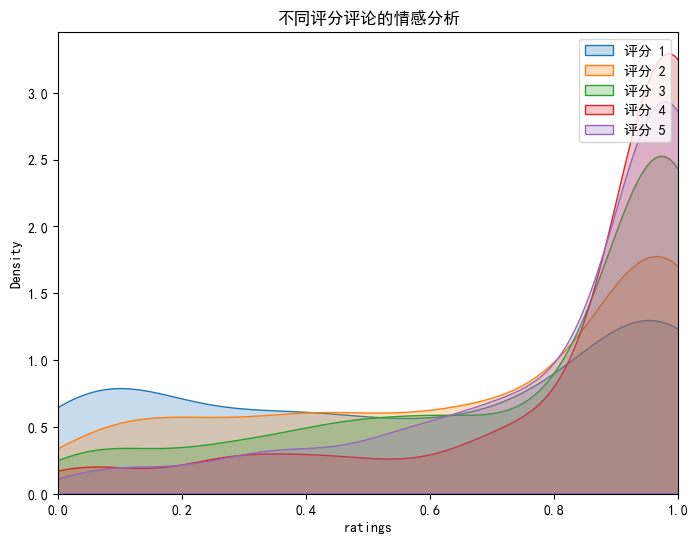

In [43]:

# 使用groupby对数据进行分组
grouped = df.groupby('ratings')

# 创建一个绘图区域
plt.figure(figsize=(8, 6))

# 遍历分组并绘制核密度图
for name, group in grouped:
    sns.kdeplot(group['sentiment'], label=f'评分 {name}', shade=True, common_norm=True)

# 设置 x 轴的限制
plt.xlim(0, 1)

# 添加图例和标签
plt.legend()
plt.title('不同评分评论的情感分析')
plt.xlabel('ratings')
plt.ylabel('Density')

# 显示图形
plt.show()
